In [1]:
from keras_segmentation.predict import predict,model_from_checkpoint_path
from keras_segmentation.models.config import IMAGE_ORDERING
import ipywidgets
from IPython.display import display, clear_output
import cv2
import numpy as np
from jetcam.csi_camera import CSICamera
import time
def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])


output_names = ['activation_1/truediv']
input_names = ['input_1']

import tensorflow.contrib.tensorrt as trt
import tensorflow as tf


def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


# trt_graph = get_frozen_graph('./output/mobilenet_75_segnet_tongtest_6_minimum_segment_size3.pb')
trt_graph = get_frozen_graph('./output2/mobilenetV1_75_segnet_tongtest.pb')
# trt_graph = get_frozen_graph('tftrt_inference.pb')
# Create session and load graph

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')


# Get graph input size
for node in trt_graph.node:
    if 'input_' in node.name:
        size = node.attr['shape'].shape
        image_size = [size.dim[i].size for i in range(1, 4)]
        break
# print("image_size: {}".format(image_size))


# input and output tensor names.
input_tensor_name = input_names[0] + ":0"
output_tensor_name = output_names[0] + ":0"

print("input_tensor_name: {}\noutput_tensor_name: {}".format(
    input_tensor_name, output_tensor_name))

output_tensor = tf_sess.graph.get_tensor_by_name(output_tensor_name)

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

def predict(_image) :
    _x = np.expand_dims(_image, axis=0)
#     _x = preprocess_input(_x)
    feed_dict = {
    input_tensor_name: _x
    }
    _netout = tf_sess.run(output_tensor, feed_dict)
    return _netout

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.gfile.GFile.
input_tensor_name: input_1:0
output_tensor_name: activation_1/truediv:0


In [2]:
def get_image_array(image_input, width, height, imgNorm="sub_mean",
                  ordering='channels_first'):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif  isinstance(image_input, six.string_types)  :
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}".format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

In [3]:
import busio
import board
import struct
from adafruit_bus_device.i2c_device import I2CDevice
camera = CSICamera(width=320, height=240, capture_width=320, capture_height=240, capture_fps=60)
DEVICE_ADDRESS = 0x12
comm_port = busio.I2C(board.SCL, board.SDA)
bus_device = I2CDevice(comm_port, DEVICE_ADDRESS)



In [4]:
# from car_lib import *
# def find_target_point(imag_1234,y_pol = 60):
#     xxxcccv =0 
#     xxxcccv_b =0 
#     px_x = 0
    
#     path_geny = np.zeros((1,2))

#     px_x = 0
#     prx = imag_1234[y_pol:y_pol+1][0:64]
#     for c in range(len(prx[0])) :
#         xxxcccv = prx[0][c]
#         if xxxcccv == 4 and xxxcccv_b == 3 :
#             px_x = c
        
#         xxxcccv_b = xxxcccv

#     if px_x != 0 :
#         _pts = np.float32([[[px_x*2.5, y_pol*1.875]]])
#         _dst = cv2.perspectiveTransform(_pts, perspective_M)
#         _dst = _dst[0][0]

#         path_geny[0][0] =_dst[0]
#         path_geny[0][1] =_dst[1]
#     else :
#         path_geny[0][0] =0
#         path_geny[0][1] =0
#     y_pol = y_pol+5
#     return  path_geny 


In [5]:
def PersTransform():
    ## scale = 1,2,4 // 640,320,160,
    scale = 2
    src = np.float32([(206/scale,111/scale), (112/scale,105/scale), (65/scale,187/scale), (258/scale,190/scale)])
#     src = np.float32([(202/scale,82/scale), (122/scale,82/scale), (81/scale,160/scale), (242/scale,160/scale)])

    scale = 4
    sx =320/scale
    sy = 140/scale
    a4_width = 120/scale
    a4_height = 270/scale
    dst = np.float32([(sx+a4_width, sy), (sx-a4_width, sy), (sx-a4_width,sy+a4_height), (sx+a4_width,sy+a4_height) ])
    M = cv2.getPerspectiveTransform(src, dst)
    return  M


In [6]:
def find_target_point(imag_1234,y_pol = 60,y_pollan = 30):
    xxxcccv =0 
    xxxcccv_b =0 
    px_x = 0

    path_geny = np.zeros((3,2))

    px_x = 0
    OBJ5 = 0 
    OBJ5_num = 0
    OBJ5 = 0 
    OBJ5_num = 0
    LANDR = 0 
    LANDR_num = 0
    LANDB = 0 
    LANDB_num = 0
    prx = imag_1234[y_pol:y_pol+1][0:64]
    for c in range(len(prx[0])) :
        xxxcccv = prx[0][c]
        
        if imag_1234[y_pollan][c] == 4 :
            LANDB_num=LANDB_num+1
            LANDB = LANDB+c
        if imag_1234[y_pollan][c] == 3 :
            LANDR_num=LANDR_num+1
            LANDR = LANDR+ c
        if xxxcccv == 5 :
            OBJ5_num=OBJ5_num+1
            OBJ5 = OBJ5+c

    if LANDR_num != 0 :
        LANDR = LANDR/LANDR_num
    if LANDB_num != 0 :
        LANDB = LANDB/LANDB_num
    if OBJ5_num != 0 :
        OBJ5 = OBJ5/OBJ5_num
        ypic = 64 - y_pol
        for zxc in range(ypic) :
            if(imag_1234[zxc+y_pol][int(OBJ5)] == 4) :
                path_geny[2][0] = 1
                break
            if(imag_1234[zxc+y_pol][int(OBJ5)] == 3) :
                path_geny[2][0] = 2
                break
            if(imag_1234[zxc+y_pol][int(OBJ5)] == 2) :
                path_geny[2][0] = 0
                break

    # if px_x != 0 :
    _ptsR = np.float32([[[LANDR*2.5, y_pollan*1.875]]])
    _ptsB = np.float32([[[LANDB*2.5, y_pollan*1.875]]])
    _dstR = cv2.perspectiveTransform(_ptsR, PersTransform())
    _dstB = cv2.perspectiveTransform(_ptsB, PersTransform())
    _dstR = _dstR[0][0]
    _dstB = _dstB[0][0]

    if LANDR != 0 :
        path_geny[0][0] =_dstR[0]
        path_geny[0][1] = LANDR_num
    else :
        path_geny[0][0] =0

    if LANDB != 0 :
        path_geny[1][0] =_dstB[0]
        path_geny[1][1] = LANDB_num
    else :
        path_geny[1][0] =0
        
    return  path_geny

In [7]:
import ipywidgets
from IPython.display import display
import cv2

def car_control(speed, steering):
    if speed > 30000:
        speed = 30000
    if speed < -30000:
        speed = -30000    
    if steering > 2500:
        steering = 2500
    if steering < -2500:
        steering = -2500    
    bus_device.write(struct.pack('>hh', int(speed), int(steering)))
    
def car_stop():
    bus_device.write(struct.pack('>hh', 0, 0))
    
def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

# img = cv2.imread('1.jpg')

image_widget = ipywidgets.Image(format='jpeg')
image_widget3 = ipywidgets.Image(format='jpeg')
image_widget2 = ipywidgets.Label('tong')
image_widget2.value = 'number'

display(image_widget3,image_widget,image_widget2)


Image(value=b'', format='jpeg')

Image(value=b'', format='jpeg')

Label(value='number')

In [10]:
import time
time10hz = 0
time11hz = 0
camera.running = True  
time1 = 0
outtong = 0
landR = 0
landB = 0
land = 0
speed = 10

error = 0
kp = 20
kd = 50

tonglan = 2

speed_b = 200

try:
    while 1 :
        if (time.time() - time10hz) > 0.033 :
            time10hz = time.time()
      
            time2 = time1
            time1 = time.time()
            img2 = camera.value
            orininal_h = img2.shape[0]
            orininal_w = img2.shape[1]

            output_width = 64
            output_height = 64
            input_width = 128
            input_height = 128
            n_classes = 6

            x = get_image_array(img2, input_width, input_height, ordering=IMAGE_ORDERING)

            pr = predict(x)
#             time2 = time.time()
            pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)
            tong1234 = find_target_point(pr,18,24)
            landR = (tong1234[0][0])
            landB = (tong1234[1][0])
#             land = landR
            if tong1234[2][0] == 1 and tonglan ==2  :
                tonglan =1
                speed = 1
            if tong1234[2][0] == 2 and tonglan ==1 :
                tonglan =2
                speed = 1

#                 speed = 200
            if speed < speed_b :
                speed = speed+2
                kp = 40
            else :
                kp = 25
            
            if tonglan == 1 :
                land = landR
            if tonglan == 2 :
                land = landB  
            target = 80 -land 
            error_current = target 
            error_dot = error_current - error
            error = error_current

            output = error * kp + error_dot* kd
            steering_angleout = output
#             steering = lan - ()
            if tong1234[0][0] != 0 or tong1234[1][0] != 0 :
                if land != 0 :
                    car_control(speed*1.5, steering_angleout)
            
            

#             print(steering_angle)
#             print(time2-time1)
        if (time.time() - time11hz) > 0.2 :
            time11hz = time.time()
            seg_img = np.zeros((64, 64, 3))
            colors = [(0, 0, 0),
             (255, 0, 0),
             (0, 255, 0),
             (0, 0, 255),
             (255, 255, 0),
             (0, 242, 255)
            ]

            for c in range(6):
                seg_img[:, :, 0] += ((pr[:, :] == c)*(colors[c][0])).astype('uint8')
                seg_img[:, :, 1] += ((pr[:, :] == c)*(colors[c][1])).astype('uint8')
                seg_img[:, :, 2] += ((pr[:, :] == c)*(colors[c][2])).astype('uint8')

            seg_img = cv2.resize(seg_img, (320, 240))
            seg_img = seg_img.astype('uint8')
            seg_img_t  = seg_img[5:240,5:320]
            seg_img_t = cv2.resize(seg_img_t,(320,240))
            tong6789 = cv2.addWeighted(img2,0.2,seg_img_t,0.80,0)
            image_widget.value = bgr8_to_jpeg(tong6789)
#             image_widget3.value = bgr8_to_jpeg(img2)
            image_widget2.value = 'fps'+str(1/(time1-time2))+ ' lanmR = '+str((tong1234[0][0])-80)+ ' lanmB = '+str((tong1234[1][0])-80) + ' OJ = '+str(target)
#             image_widget2.value = 'fps'+str(1/(time1-time2))+' lanL = '+str(genx[0][5])+' lanR = '+str(genx[1][5])+'  avg = '+str(tonglan)
            
except KeyboardInterrupt:
    car_control(10, steering_angleout)
    time.sleep(0.5)
    car_stop()
    camera.running = False  

In [31]:
camera.running = False

In [78]:
def find_target_point(imag_1234,y_pol = 60):
    xxxcccv =0 
    xxxcccv_b =0 
    px_x = 0
    
    path_geny = np.zeros((1,2))

    px_x = 0
    prx = imag_1234[y_pol:y_pol+1][0:64]
    for c in range(len(prx[0])) :
        xxxcccv = prx[0][c]
        if xxxcccv == 4 and xxxcccv_b == 3 :
            px_x = c
#         elif xxxcccv == 5 and xxxcccv_b == 3
        
        xxxcccv_b = xxxcccv

    if px_x != 0 :
        _pts = np.float32([[[px_x*2.5, y_pol*1.875]]])
        _dst = cv2.perspectiveTransform(_pts, perspective_M)
        _dst = _dst[0][0]

        path_geny[0][0] =_dst[0]
        path_geny[0][1] =_dst[1]
    else :
        path_geny[0][0] =0
        path_geny[0][1] =0
    y_pol = y_pol+5
    return  path_geny 


[[ 59.33701324  27.        ]
 [130.20649719  17.        ]
 [  0.           0.        ]]


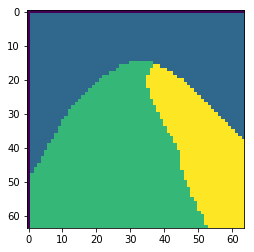

In [24]:
camera.running = True  
import matplotlib.pyplot as plt

img2 = camera.value
orininal_h = img2.shape[0]
orininal_w = img2.shape[1]

output_width = 64
output_height = 64
input_width = 128
input_height = 128
n_classes = 6

x = get_image_array(img2, input_width, input_height, ordering=IMAGE_ORDERING)

pr = predict(x)
#             time2 = time.time()
pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)
y_pol = 21
imag_1234 = pr 
xxxcccv =0 
xxxcccv_b =0 
px_x = 0

path_geny = np.zeros((3,2))

px_x = 0
OBJ5 = 0 
OBJ5_num = 0
LANDR = 0 
LANDR_num = 0
LANDB = 0 
LANDB_num = 0

y_pollan = 30

prx = imag_1234[y_pol:y_pol+1][0:64]
for c in range(len(prx[0])) :
    xxxcccv = prx[0][c]

    if imag_1234[y_pollan][c] == 4 :
        LANDB_num=LANDB_num+1
        LANDB = LANDB + c
    if imag_1234[y_pollan][c] == 3 :
        LANDR_num=LANDR_num+1
        LANDR = LANDR + c
    if xxxcccv == 5 :
        OBJ5_num=OBJ5_num+1
        OBJ5 = OBJ5+c

if LANDR_num != 0 :
    LANDR = LANDR/LANDR_num
if LANDB_num != 0 :
    LANDB = LANDB/LANDB_num
if OBJ5_num != 0 :
    OBJ5 = OBJ5/OBJ5_num
    ypic = 64 - y_pol
    for zxc in range(ypic) :
        if(imag_1234[zxc+y_pol][int(OBJ5)] == 4) :
            path_geny[2][0] = 1
            break
        if(imag_1234[zxc+y_pol][int(OBJ5)] == 3) :
            path_geny[2][0] = 2
            break

# if px_x != 0 :
_ptsR = np.float32([[[LANDR*2.5, y_pollan*1.875]]])
_ptsB = np.float32([[[LANDB*2.5, y_pollan*1.875]]])
_dstR = cv2.perspectiveTransform(_ptsR, PersTransform())
_dstB = cv2.perspectiveTransform(_ptsB, PersTransform())
_dstR = _dstR[0][0]
_dstB = _dstB[0][0]

if LANDR != 0 :
    path_geny[0][0] =_dstR[0]
    path_geny[0][1] = LANDR_num
else :
    path_geny[0][0] =0

if LANDB != 0 :
    path_geny[1][0] =_dstB[0]
    path_geny[1][1] = LANDB_num
else :
    path_geny[1][0] =0
    
# y_pol = y_pol+5
# prx = pr[22:22+1][0:64]
plt.imshow(imag_1234)
camera.running = False 
print(path_geny) 

In [22]:
imag_1234[60][40]

3

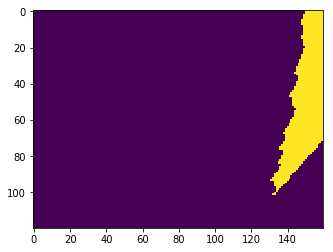

In [367]:

# BGRttt = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)
# # path_gen, pts_raw_y, pts_raw_w, img_thresh_y, img_thresh_w =lane_detection_all_image (BGRttt, y_thresh, w_thresh)

y_thresh = 200
w_thresh = 230

seg_img = seg_img.astype('uint8')
seg_img_t = seg_img[5:240,5:320]
image_t = cv2.resize(seg_img_t,(160,120), interpolation = cv2.INTER_LINEAR)
top_downtong = corners_unwarp(image_t, mtx, dist, perspective_M)
img_thresh_l = thresholdIMG_L(top_downtong, y_thresh)
img_thresh_r = thresholdIMG_R(top_downtong, w_thresh)
pts_raw_l, img_thresh_l = findLane_160_Y(img_thresh_l, visualise = False)
pts_raw_r, img_thresh_r = findLane_160_W(img_thresh_r, visualise = False)  
pts_raw_l = pts_raw_l.reshape((int(pts_raw_l.size/3),3))
pts_raw_r = pts_raw_r.reshape((int(pts_raw_r.size/3),3))

    
image_widget.value = bgr8_to_jpeg(image)
import matplotlib.pyplot as plt
plt.imshow(img_thresh_r)

In [374]:
camera.running = False 


In [ ]:
image = cv2.resize(image,(160,120), interpolation = cv2.INTER_LINEAR)


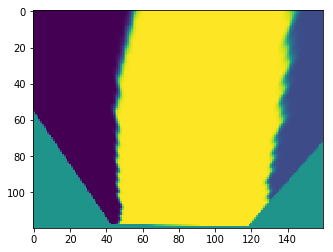

In [353]:
ho = 150

image2 = cv2.resize(image2,(160,120))

lab = cv2.cvtColor(top_downtong, cv2.COLOR_BGR2LAB).astype(np.float)
y_channel = lab[:,:,1]
y_binary = np.zeros_like(y_channel)
y_binary[(y_channel<=ho)] = 1

import matplotlib.pyplot as plt
plt.imshow(y_channel)

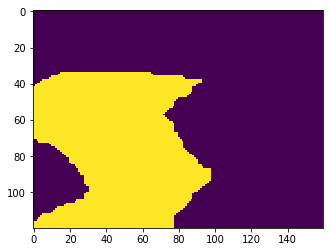

In [283]:
ho = 150
image2 = image[5:120,5:160]
image2 = cv2.resize(image2,(160,120))
lab = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB).astype(np.float)
y_channel = lab[:,:,0]
y_binary = np.zeros_like(y_channel)
y_binary[(y_channel<=ho)] = 1

import matplotlib.pyplot as plt
plt.imshow(y_binary)

In [59]:
camera.running = False 

In [ ]:


def thresholdIMG_R(img, y_thresh = 200):

    # Convert to LAB color space, and use the B channel (yellow)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float)
    y_channel = lab[:,:,0]
    y_binary = np.zeros_like(y_channel)
    y_binary[(y_channel>=y_thresh)] = 1

    return y_binary

def thresholdIMG_L(img, w_thresh = 230):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float)
    w_channel = lab[:,:,1]
    w_binary = np.zeros_like(w_channel)
    w_binary[(w_channel>=w_thresh)] = 1
    
    return w_binary

def detection_image (image, l_level = 200, r_level = 230):
    image_t = cv2.resize(image,(160,120), interpolation = cv2.INTER_LINEAR)
    top_downtong = corners_unwarp(image_t, mtx, dist, perspective_M)
    img_thresh_l = thresholdIMG_L(top_downtong, l_level)
    img_thresh_r = thresholdIMG_R(top_downtong, r_level)
    pts_raw_l, img_thresh_l = findLane_160_Y(img_thresh_l, visualise = False)
    pts_raw_r, img_thresh_r = findLane_160_W(img_thresh_r, visualise = False)  
    pts_raw_l = pts_raw_l.reshape((int(pts_raw_l.size/3),3))
    pts_raw_r = pts_raw_r.reshape((int(pts_raw_r.size/3),3))

    path_gen = np.zeros((6,8))
    position_from_l = -1
    position_from_r = -1
    for y_step in range(8):    

        for x_step_y in range(pts_raw_l.shape[0]):  
            if pts_raw_l[x_step_y,0] == y_step :
                position_from_l = pts_raw_l[x_step_y,1]

        for x_step_w in range(pts_raw_r.shape[0]):  
            if pts_raw_r[x_step_w,0] == y_step :
                position_from_r = pts_raw_r[x_step_w,1]

        avg_num = 0
        avg_value = 0
        if position_from_l >= 0 :
            avg_num = avg_num + 1 
            avg_value = avg_value +  position_from_l 
            avg_num = avg_num + 1 
            avg_value = avg_value +  position_from_l 


        path_gen[0,y_step] = 0
        path_gen[4, y_step] = 0
        if avg_num > 0:
            path_gen[0, y_step] = avg_value/avg_num
            path_gen[4, y_step] = 1

        avg_num2 = 0
        avg_value2 = 0
        if position_from_r >= 0 :
            avg_num2 = avg_num2 + 1 
            avg_value = avg_value + position_from_r 
            avg_num2 = avg_num2 + 1 
            avg_value = avg_value + position_from_r 

        path_gen[1,y_step] = 0
        path_gen[5, y_step] = 0
        if avg_num2 > 0:
            path_gen[1, y_step] = avg_value/avg_num2
            path_gen[5, y_step] = 1

    tong_x = 0
    tong_avg = 0
    if path_gen[4][5] == 1 :
        tong_x = ((55+path_gen[0][5])-80)
        tong_avg = tong_avg+1
    if path_gen[5][5] == 1 :
        tong_x = ((path_gen[1][5] - 55)-80)
        tong_avg = tong_avg+1
        
    tong_x = tong_x/tong_avg
    
    return tong_x,path_gen